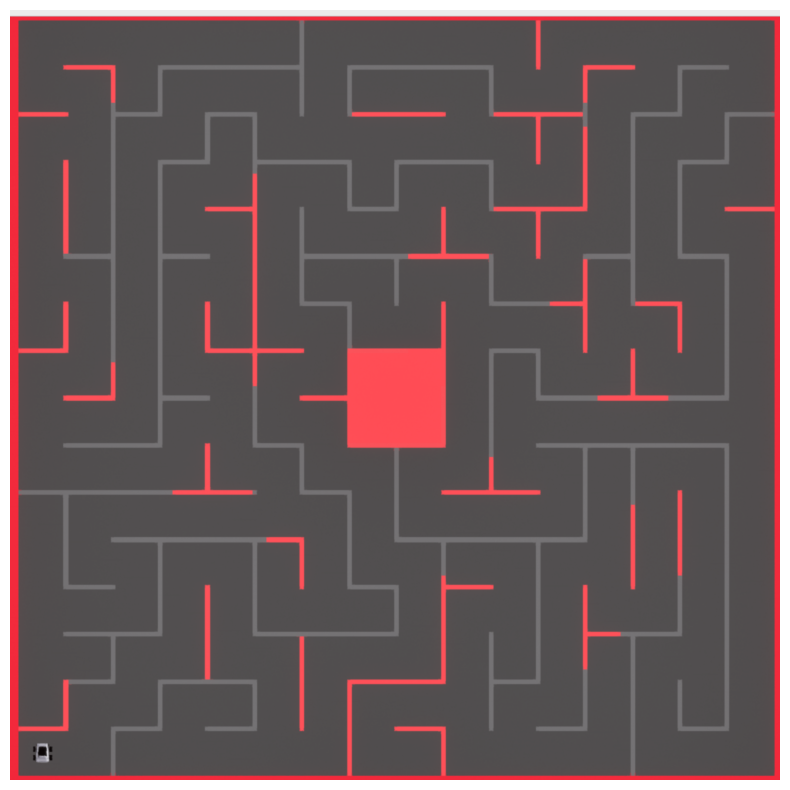

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from queue import deque
# Load the image
image_path = '../data/image6.png'
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Crop the center of the image
height, width = original_image.shape[:2]
crop_width, crop_height = 2000, 2000
start_x = (width - crop_width) // 2
start_y = (height - crop_height + 50) // 2
cropped_image = original_image[start_y:start_y+crop_height, start_x:start_x+crop_width]

# Display the cropped image
plt.figure(figsize=(10, 10))
plt.imshow(cropped_image)
plt.axis('off')
plt.show()


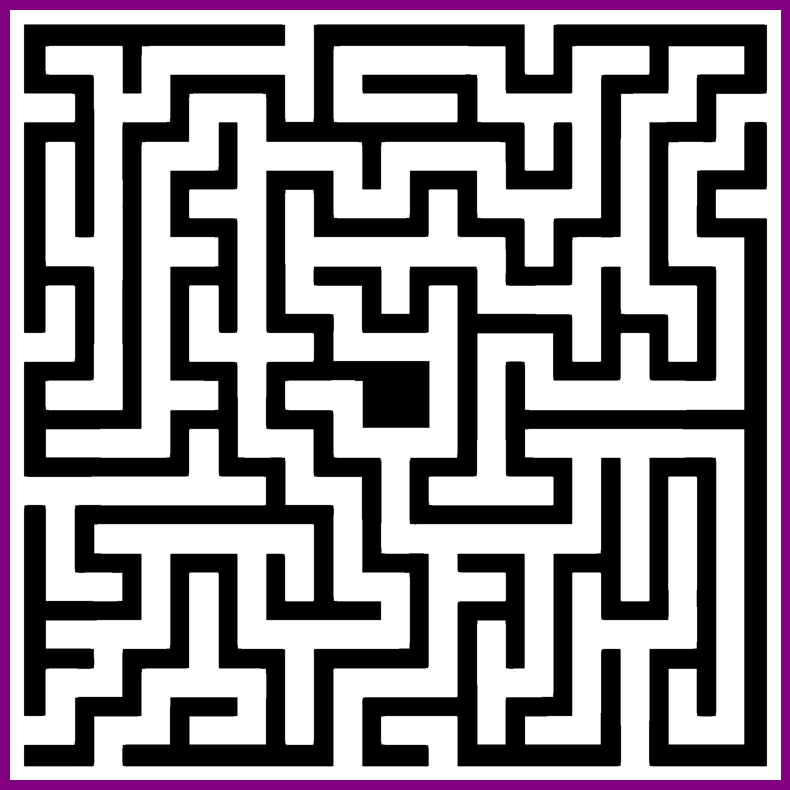

In [76]:

# Convert to grayscale and apply threshold
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
_, binary_image = cv2.threshold(gray_image, 90, 255, cv2.THRESH_BINARY)

#cut out robot
cv2.rectangle(binary_image, (50, 1880), (50 + 80, 1880 + 80),
              color=(1, 1, 1, 1), thickness=-1)
#cut out red floor
cv2.rectangle(binary_image, (crop_width//2 - 110, crop_height//2 - 110),
              (crop_width//2 + 120, crop_height//2 + 120), color=(1, 1, 1, 1), thickness=-1)
# #cut out entrance
cv2.rectangle(binary_image, (crop_width//2 - 130, crop_height//2 - 110),
              (crop_width//2, crop_height//2), color=(1, 1, 1, 1), thickness=-1)



def find_nearest_black_pixel(binary_image, start):
    """
    Find the nearest black pixel from the given start coordinate.

    Parameters:
    - binary_image: 2D numpy array with binary values (0 or 255).
    - start: Tuple of (y, x) for the starting coordinates.

    Returns:
    - The coordinates of the nearest black pixel as a (y, x) tuple.
    """
    height, width = binary_image.shape

    # Directions for moving in 8 possible directions (N, NE, E, SE, S, SW, W, NW)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]

    # Use a queue to facilitate BFS
    queue = deque([start])
    visited = set()
    visited.add(start)

    while queue:
        current_y, current_x = queue.popleft()
        if binary_image[current_y, current_x] == 0:
            return (current_y, current_x)
        for dy, dx in directions:
            new_y, new_x = current_y + dy, current_x + dx
            if 0 <= new_y < height and 0 <= new_x < width and (new_y, new_x) not in visited:
                visited.add((new_y, new_x))
                queue.append((new_y, new_x))

    return None


nearest_black_from_top_left = find_nearest_black_pixel(binary_image, (0, 0))
max_y, max_x = binary_image.shape[0] - 1, binary_image.shape[1] - 1
nearest_black_from_bottom_right = find_nearest_black_pixel(
    binary_image, (max_y, max_x))

margin = 7

final_image = binary_image[nearest_black_from_top_left[0]-margin:nearest_black_from_bottom_right[0] +
                            margin, nearest_black_from_top_left[1]-margin:nearest_black_from_bottom_right[1]+margin]

kernel = np.ones((5, 5), np.uint8) 
  
final_image = cv2.dilate(final_image, kernel, iterations=15)
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("purple")
plt.imshow(final_image, cmap='gray')
plt.axis('off')
plt.show()

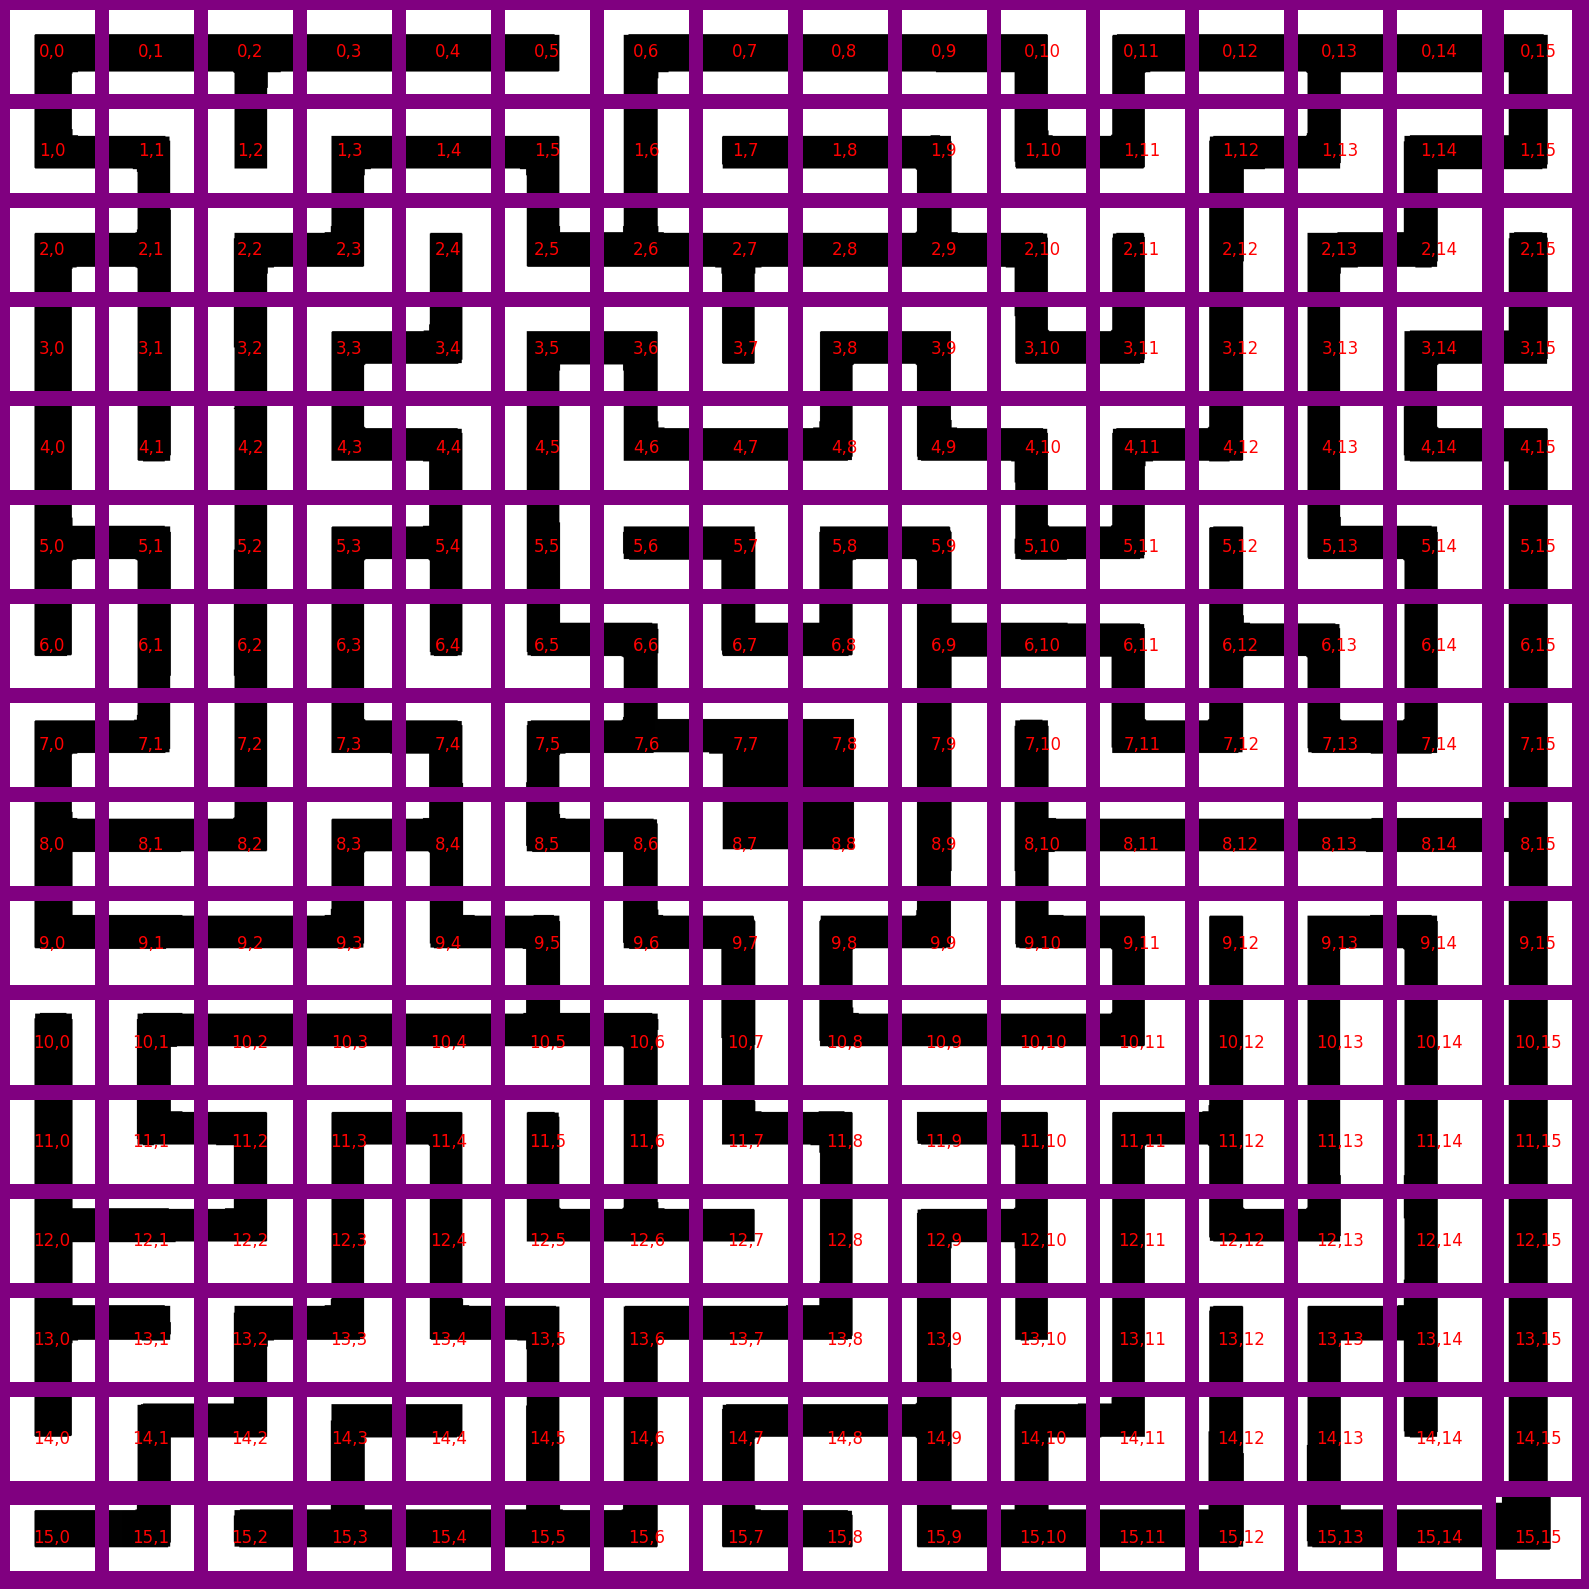

Slice (0, 0): {'N': True, 'E': False, 'W': True, 'S': False}
Slice (0, 1): {'N': True, 'E': False, 'W': False, 'S': True}
Slice (0, 2): {'N': True, 'E': False, 'W': False, 'S': False}
Slice (0, 3): {'N': True, 'E': False, 'W': False, 'S': True}
Slice (0, 4): {'N': True, 'E': False, 'W': False, 'S': True}
Slice (0, 5): {'N': True, 'E': True, 'W': False, 'S': True}
Slice (0, 6): {'N': True, 'E': False, 'W': True, 'S': False}
Slice (0, 7): {'N': True, 'E': False, 'W': False, 'S': True}
Slice (0, 8): {'N': True, 'E': False, 'W': False, 'S': True}
Slice (0, 9): {'N': True, 'E': False, 'W': False, 'S': True}
Slice (0, 10): {'N': True, 'E': True, 'W': False, 'S': False}
Slice (0, 11): {'N': True, 'E': False, 'W': True, 'S': False}
Slice (0, 12): {'N': True, 'E': False, 'W': False, 'S': True}
Slice (0, 13): {'N': True, 'E': False, 'W': False, 'S': False}
Slice (0, 14): {'N': True, 'E': False, 'W': False, 'S': True}
Slice (0, 15): {'N': True, 'E': True, 'W': False, 'S': False}
Slice (1, 0): {'N

In [80]:

# Define parameters for slicing
rows, cols = 16, 16
slice_width, slice_height = crop_width // cols, crop_height // rows

wall_buffer_width = 3  # Buffer area to account for wall thickness
wall_buffer_height = 3  # Buffer area to account for wall thickness

# Slicing the image from the center of each slice
slices = {}
for i in range(16):
    for j in range(16):
        y = i * slice_height
        x = j * slice_width
        slice_img = final_image[y:y+slice_height, x:x+slice_width]
        slices[(i, j)] = slice_img

# Function to detect sides in a slice
def detect_sides(slice_img):
    sides = {'N': False, 'E': False, 'W': False, 'S': False}
    
    # Check North side
    if np.all(slice_img[0, :]  == 255):
        sides['N'] = True
    
    # Check East side
    if np.all(slice_img[:, -1] == 255):
        sides['E'] = True
    
    # Check West side
    if np.all(slice_img[:, 0] == 255):
        sides['W'] = True
    
    # Check South side
    if np.all(slice_img[-1, :] == 255):
        sides['S'] = True

    return sides

# Detect sides for each slice
slice_sides = {}
for (i, j), slice_img in slices.items():
    slice_sides[(i, j)] = detect_sides(slice_img)

# Display a sample of slices with detected sides
fig, axs = plt.subplots(16, 16, figsize=(16, 16))
fig.set_facecolor("purple")

for (i, j), slice_img in slices.items():
    row = i
    col = j
    axs[row, col].imshow(slices[(i, j)], cmap='gray')
    axs[row, col].axis('off')
        # Annotate with cell number
    axs[row, col].text(0.5, 0.5, f"{i},{j}", fontsize=12, color='red',
                       ha='center', va='center', transform=axs[row, col].transAxes)


plt.tight_layout()
plt.show()

for (i, j), sides in slice_sides.items():
    print(f"Slice ({i}, {j}): {sides}")

In [78]:

def calculate_cell_value(walls):
    if not walls['W'] and not walls['N'] and not walls['E'] and not walls['S']:
        return 0
    elif walls['W'] and not walls['N'] and not walls['E'] and not walls['S']:
        return 1
    elif not walls['W'] and walls['N'] and not walls['E'] and not walls['S']:
        return 2
    elif not walls['W'] and not walls['N'] and walls['E'] and not walls['S']:
        return 3
    elif not walls['W'] and not walls['N'] and not walls['E'] and walls['S']:
        return 4
    elif walls['W'] and not walls['N'] and not walls['E'] and walls['S']:
        return 5
    elif not walls['W'] and not walls['N'] and walls['E'] and walls['S']:
        return 6
    elif not walls['W'] and walls['N'] and walls['E'] and not walls['S']:
        return 7
    elif walls['W'] and walls['N'] and not walls['E'] and not walls['S']:
        return 8
    elif walls['W'] and not walls['N'] and walls['E'] and not walls['S']:
        return 9
    elif not walls['W'] and walls['N'] and not walls['E'] and walls['S']:
        return 10
    elif not walls['W'] and walls['N'] and walls['E'] and walls['S']:
        return 11
    elif walls['W'] and walls['N'] and walls['E'] and not walls['S']:
        return 12
    elif walls['W'] and walls['N'] and not walls['E'] and walls['S']:
        return 13
    elif walls['W'] and not walls['N'] and walls['E'] and walls['S']:
        return 14
    elif walls['W'] and walls['N'] and walls['E'] and walls['S']:
        return 15

matrix = [[0 for _ in range(16)] for _ in range(16)]

# Print the detected sides for all slices
for (i, j), sides in slice_sides.items():
    matrix[i][j] = calculate_cell_value(sides)

print("[")
for row in matrix:
    print("\t"+str(row) + ",")
print("]")


[
	[8, 10, 2, 10, 10, 11, 8, 10, 10, 10, 7, 8, 10, 2, 10, 7],
	[5, 7, 14, 8, 10, 7, 9, 13, 10, 7, 5, 6, 8, 6, 8, 6],
	[8, 3, 8, 6, 12, 5, 4, 2, 10, 4, 7, 12, 9, 8, 6, 12],
	[9, 9, 9, 8, 6, 8, 7, 14, 8, 7, 5, 6, 9, 9, 8, 6],
	[9, 14, 9, 5, 7, 9, 5, 10, 6, 5, 7, 8, 6, 9, 5, 7],
	[1, 7, 9, 8, 3, 9, 13, 7, 8, 7, 5, 6, 12, 5, 7, 9],
	[14, 9, 9, 9, 14, 5, 7, 5, 6, 1, 10, 7, 1, 7, 9, 9],
	[8, 6, 9, 5, 7, 8, 4, 2, 7, 9, 12, 5, 6, 5, 6, 9],
	[1, 10, 6, 8, 3, 5, 7, 5, 6, 9, 1, 10, 10, 10, 10, 3],
	[5, 10, 10, 6, 5, 7, 5, 7, 8, 6, 5, 7, 12, 8, 7, 9],
	[12, 8, 10, 10, 10, 4, 7, 9, 5, 10, 10, 6, 9, 9, 9, 9],
	[9, 5, 7, 8, 7, 12, 9, 5, 7, 13, 7, 8, 3, 9, 9, 9],
	[1, 10, 6, 9, 9, 5, 4, 11, 9, 8, 3, 9, 5, 6, 9, 9],
	[1, 11, 8, 6, 5, 7, 8, 10, 6, 9, 14, 9, 12, 8, 3, 9],
	[14, 8, 6, 8, 11, 9, 9, 8, 10, 3, 8, 6, 9, 9, 14, 9],
	[13, 6, 13, 4, 10, 4, 6, 5, 11, 5, 4, 10, 6, 5, 10, 6],
]
